7.092529976407431e+25
2.663256141220824e+25


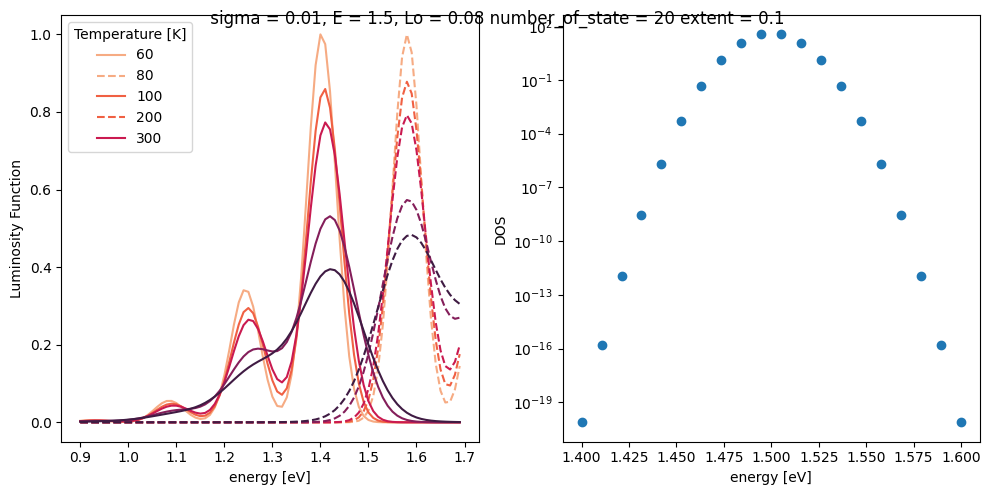

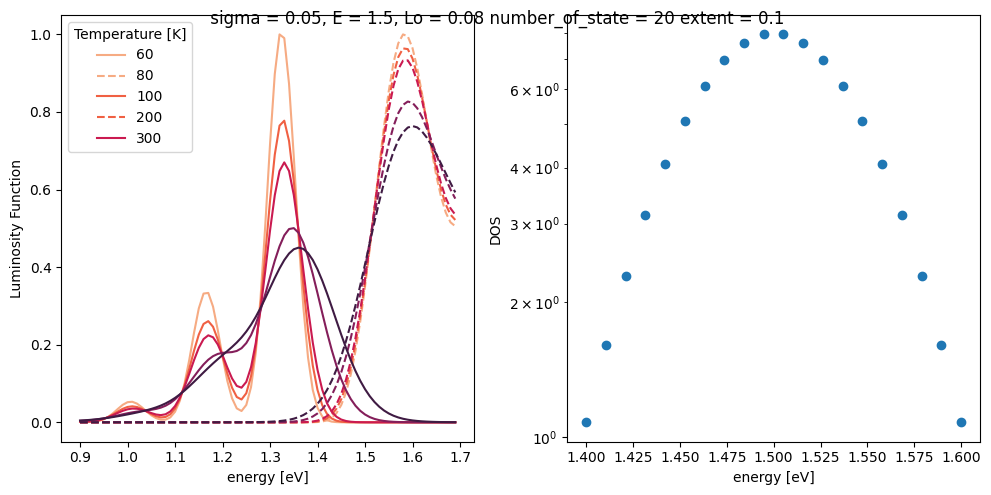

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pl_temp_fit.model_function import LTL


def pl_trial(
    temperature_list_pl,
    hws_pl,
    fixed_parameters_dict={},
    params_to_fit={},
):
    """Run the model to generate the  PL spectra.

    Args:
    ----
    temperature_list_pl (np.array): The temperature list for the PL spectra
    hws_pl (np.array): The photon energies for the PL spectra
    fixed_parameters_dict (dict): The fixed parameters for the model in a dictionary for the different classes
    params_to_fit (dict): The parameters to fit in the model

    Returns:
    -------
    tuple: The model data for the PL spectra and the radiative and non-radiative recombination rates

    """
    data = LTL.Data()
    data.update(**fixed_parameters_dict)
    data.update(**params_to_fit)
    data.D.Luminecence_exp = "PL"
    data.D.T = temperature_list_pl  # np.array([300.0, 150.0, 80.0])
    LTL.ltlcalc(data)
    pl_results = data.D.kr_hw  # .reshape(-1, 1)
    pl_results_interp = np.zeros((len(hws_pl), len(temperature_list_pl)))
    abs_results_interp = np.zeros((len(hws_pl), len(temperature_list_pl)))
    for i in range(len(temperature_list_pl)):
        pl_results_interp[:, i] = np.interp(
            hws_pl, data.D.hw, pl_results[:, i]
        )
        abs_results_interp[:, i] = np.interp(
            hws_pl, data.D.hw, data.D.alpha[:, i]
        )
    print(pl_results_interp[pl_results_interp > 0].max())
    pl_results_interp = (
        pl_results_interp / pl_results_interp[pl_results_interp > 0].max()
    )
    abs_results_interp = (
        abs_results_interp / abs_results_interp.reshape(-1).max()
    )
    return pl_results_interp, abs_results_interp


def plot_case(E, sigma, Lo, numbrstates, disorder_extent):
    fixed_parameters_dict = {
        "EX": {"numbrstates": numbrstates, "disorder_ext": disorder_extent},
        "CT": {"off": 1},
        "D": {"hw": np.arange(0, 5, 0.01)},
    }
    true_parameters = {
        "EX": {"E": E, "sigma": sigma, "Li": 7.8e-2, "Lo": Lo, "hO": 0.159},
        "CT": {},
        "D": {},
    }
    temperature_list_pl = [60, 80, 100, 200, 300]
    hws_pl = np.arange(0.9, 1.7, 0.01)
    model_data_pl, abs_results_interp = pl_trial(
        temperature_list_pl,
        hws_pl,
        fixed_parameters_dict,
        true_parameters,
    )
    color_list = sns.color_palette("rocket_r", len(temperature_list_pl))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes[0]
    for i in range(len(temperature_list_pl)):
        ax.plot(hws_pl, model_data_pl[:, i], color=color_list[i])
        ax.plot(
            hws_pl,
            abs_results_interp[:, i],
            color=color_list[i],
            linestyle="--",
        )

    ax.set_xlabel("energy [eV]")
    ax.set_ylabel("Luminosity Function")
    ax.legend(temperature_list_pl, title="Temperature [K]")
    ax = axes[1]
    DG0 = np.linspace(E - disorder_extent, E + disorder_extent, numbrstates)
    ax.scatter(
        DG0,
        np.exp(-((DG0 - E) ** 2) / (2 * sigma**2))
        / np.sqrt(2 * np.pi * sigma**2),
        label="Gaussian",
    )
    ax.set_xlabel("energy [eV]")
    ax.set_ylabel("DOS")
    ax.set_yscale("log")
    fig.tight_layout()
    fig.suptitle(
        f" sigma = {sigma}, E = {E}, Lo = {Lo} number_of_state = {numbrstates} extent = {disorder_extent}"
    )


E, sigma, Lo, numbrstates, disorder_extent = 1.5, 0.01, 0.08, 20, 0.1
plot_case(E, sigma, Lo, numbrstates, disorder_extent)

E, sigma, Lo, numbrstates, disorder_extent = 1.5, 0.05, 0.08, 20, 0.1
plot_case(E, sigma, Lo, numbrstates, disorder_extent)

[4.97870684e+08 1.50357898e+09 2.50420097e+09 3.35910981e+09
 4.06569660e+09]
[4.53999298e+05 1.80753819e+07 9.89837561e+07 2.63479808e+08
 4.97870684e+08]
[3.05902321e+03 7.68477620e+05 9.84795135e+06 4.27682035e+07
 1.11089965e+08]
[9.35762297e-04 5.90557852e+01 9.69821458e+03 1.82911923e+05
 1.23409804e+06]
[8.75651076e-17 3.48758576e-07 9.40553661e-03 3.34567716e+00
 1.52299797e+02]


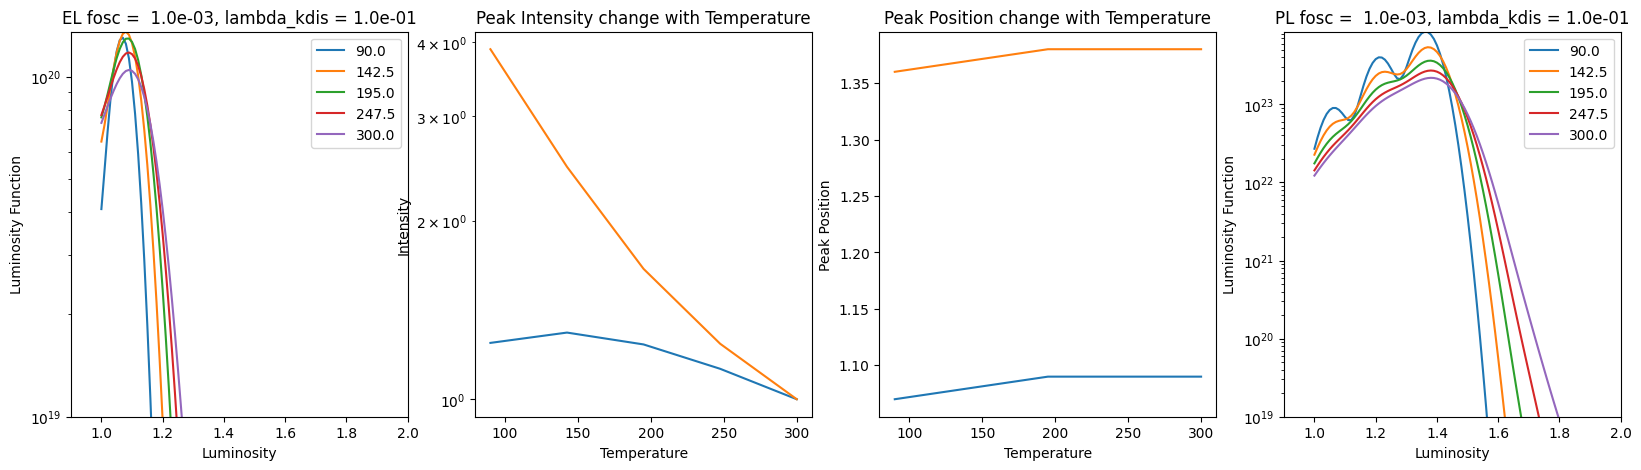

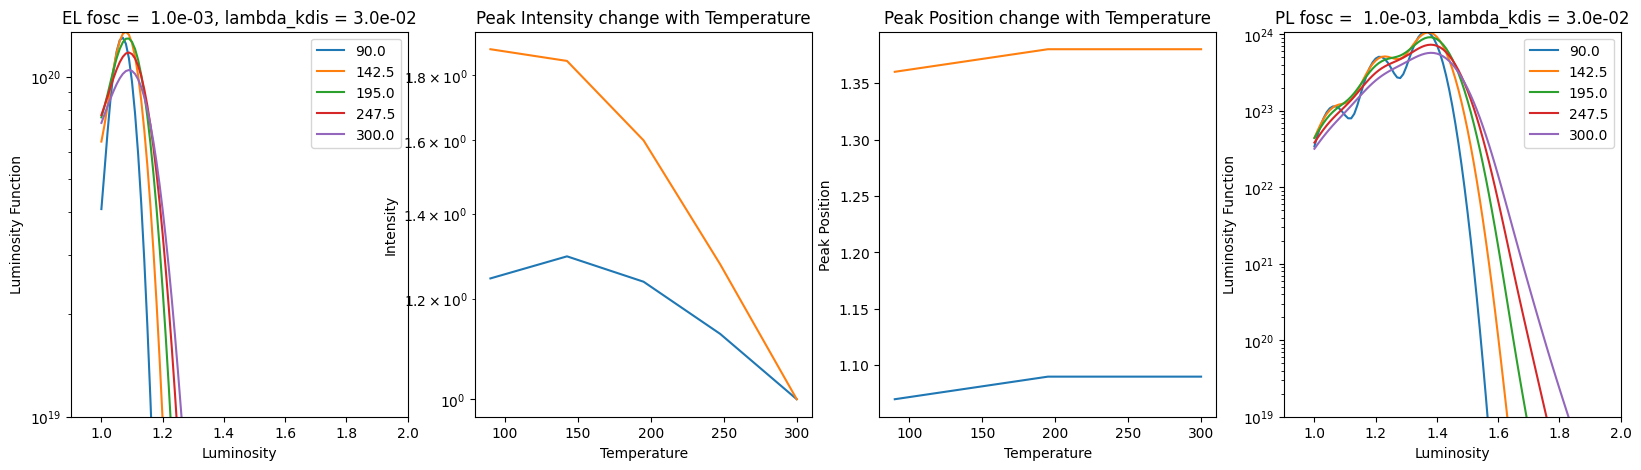

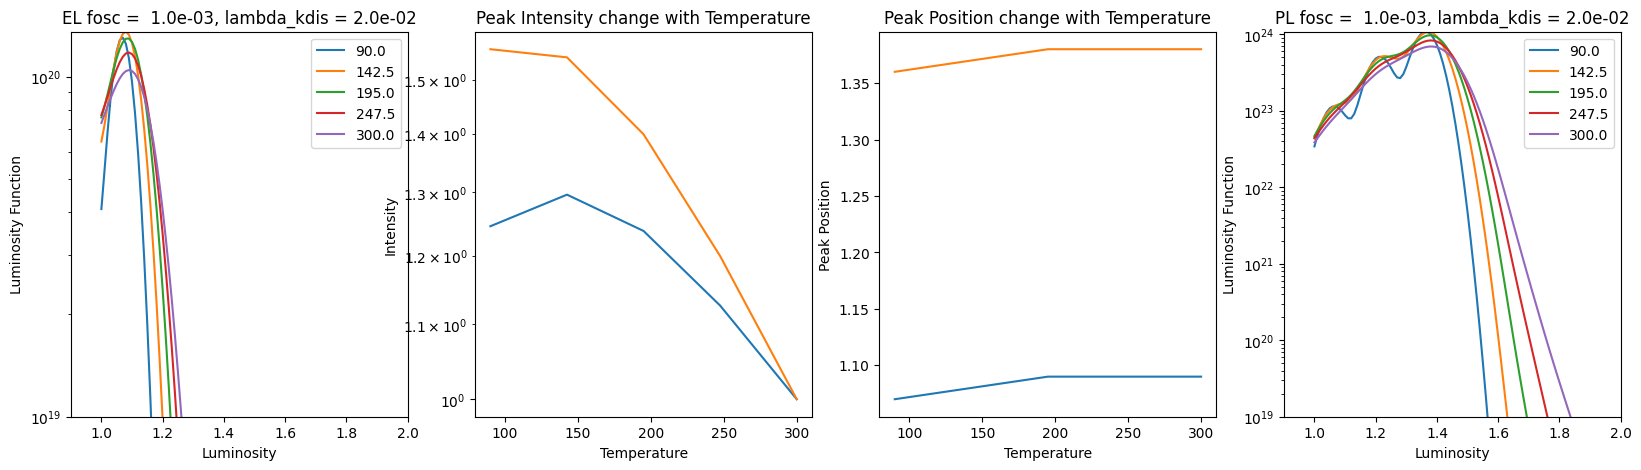

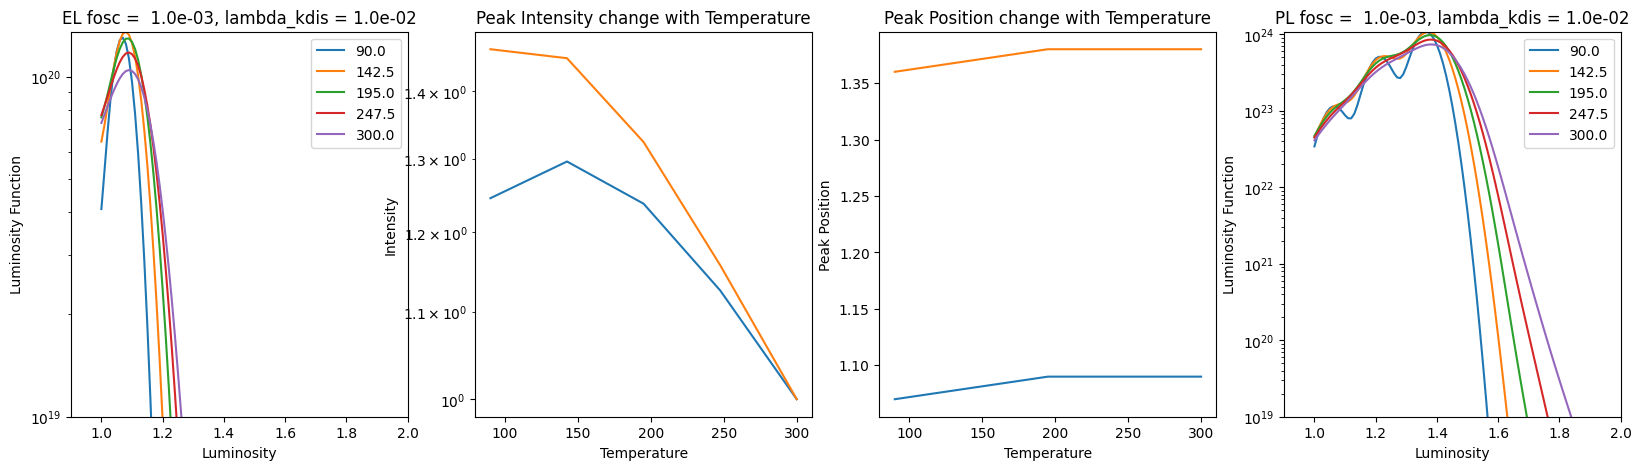

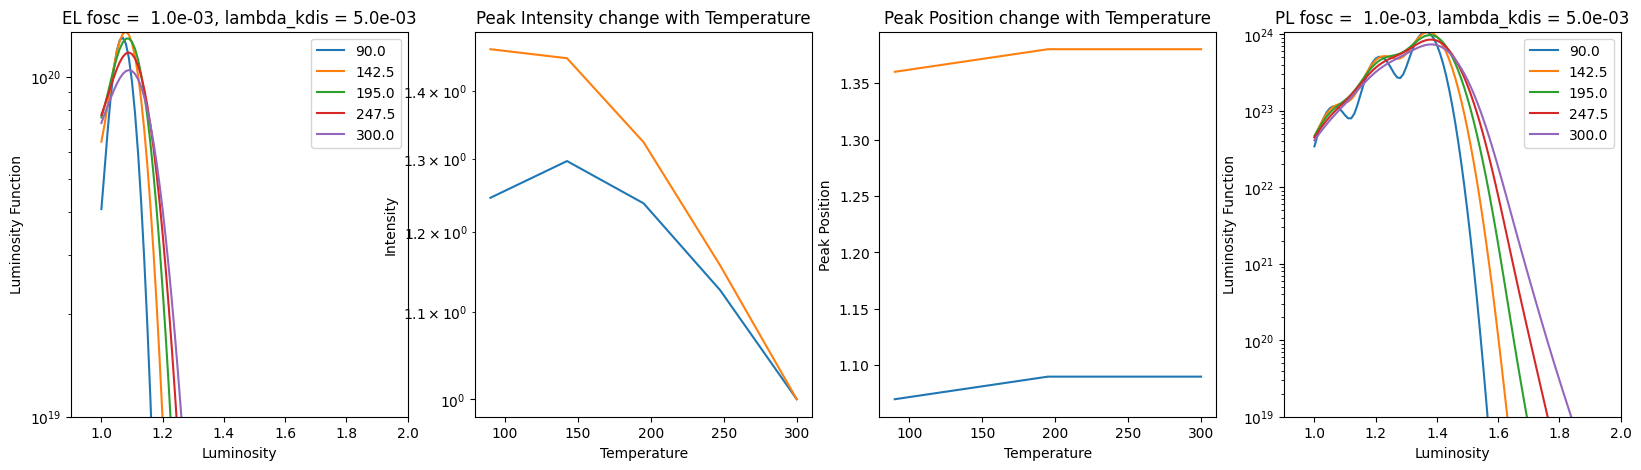

In [1]:
import importlib

importlib.reload(LTL)


def plot_data(data):
    data = LTL.ltlcalc(data)

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].plot(data.D.hw, data.D.kr_hw, label=data.D.T)
    ax[0].set_xlabel("Luminosity")
    ax[0].set_ylabel("Luminosity Function")
    ax[0].legend()
    ax[0].set_xlim(0.9, 2)
    ax[0].set_ylim(1e19, np.max(data.D.kr_hw))
    ax[0].set_yscale("log")
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw, axis=0) / np.max(data.D.kr_hw, axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw, axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[1].set_xlabel("Temperature")
    ax[1].set_ylabel("Intensity")
    ax[1].set_title("Peak Intensity change with Temperature")
    ax[1].set_yscale("log")
    ax[2].plot(data.D.T, peak_pos)
    ax[2].set_xlabel("Temperature")
    ax[2].set_ylabel("Peak Position")
    ax[2].set_title("Peak Position change with Temperature")
    data.D.Luminecence_exp = "PL"
    LTL.ltlcalc(data)

    ax[3].plot(data.D.hw, data.D.kr_hw, label=data.D.T)
    ax[3].set_xlabel("Luminosity")
    ax[3].set_ylabel("Luminosity Function")
    ax[3].legend()
    ax[3].set_xlim(0.9, 2)
    ax[3].set_ylim(1e19, np.max(data.D.kr_hw))
    ax[3].set_yscale("log")
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw, axis=0) / np.max(data.D.kr_hw, axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw, axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[2].plot(data.D.T, peak_pos)
    ax[0].set_title(f"EL fosc =  {fosc:.1e}, lambda_kdis = {lambda_kdis:.1e}")
    ax[3].set_title(f"PL fosc =  {fosc:.1e}, lambda_kdis = {lambda_kdis:.1e}")


for lambda_kdis in [0.1, 0.03, 0.02, 0.01, 0.005]:
    data = LTL.Data()
    fosc = 10**-3
    data.D.T = np.linspace(90, 300, 5)

    data.D.RCTE = 1
    data.EX = LTL.State(
        E=1.5,
        vmhigh=5,
        vmlow=15,
        sigma=0.025,
        numbrstates=20,
        off=0,
        Li=0.1,
        Lo=0.1,
        hO=0.15,
        fosc=0.5,
    )
    data.CT = LTL.State(
        E=1.2,
        vmhigh=5,
        vmlow=15,
        sigma=0.02,
        numbrstates=20,
        off=0,
        Li=0.1,
        Lo=0.1,
        hO=0.15,
        fosc=fosc,
    )
    data.D.Luminecence_exp = "EL"
    data.D.hw = np.arange(1, 2, 0.01)

    data.D.kEXCT = 1e10 * np.exp(
        -((data.EX.E - data.CT.E) ** 2)
        * ((data.c.kb * 300) / lambda_kdis / (data.c.kb * data.D.T))
    )
    plot_data(data)

    # print(np.array2string(data.EX.kr/data.EX.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
    # print(np.array2string(data.CT.kr/data.CT.knr, formatter={'float_kind':lambda x: "%.2e" % x}))
    print(data.D.kEXCT)
# print(data.CT.knr)

In [31]:
data.get_delta_voc_nr()
data.voltage_results

{'internal_quantum_efficiency': array([[0.00137743, 0.00178811, 0.00199749, 0.00201893, 0.00194319]]),
 'external_quantum_efficiency': array([[0.00028958, 0.00037603, 0.00042014, 0.00042465, 0.0004087 ]]),
 'delta_voc_nr': array([[0.06318557, 0.09683558, 0.13064839, 0.16559482, 0.20171109]])}

In [3]:
import importlib

from pl_temp_fit import LTL

importlib.reload(LTL)
data = LTL.Data()
for fosc in [0.005, 0.01]:  # 0.00005, 0.0001,0.0005, 0.001,
    data.D.RCTE = 1
    data.EX = LTL.State(
        E=1.5,
        vmhigh=5,
        vmlow=15,
        sigma=0.025,
        numbrstates=20,
        off=0,
        LI=0.1,
        L0=0.1,
        H0=0.15,
        fosc=5,
    )
    data.CT = LTL.State(
        E=1.4,
        vmhigh=5,
        vmlow=15,
        sigma=0.01,
        numbrstates=20,
        off=0,
        LI=0.1,
        L0=0.1,
        H0=0.15,
        fosc=fosc,
    )
    data.D.Luminecence_exp = "EL"
    data.D.T = np.linspace(90, 300, 5)
    data.D.kEXCT = 1e9 * np.exp(
        -((data.EX.E - data.CT.E) ** 2)
        * ((data.c.kb * 300) / 0.01 / (data.c.kb * data.D.T))
    )
    data.D.hw = np.arange(1, 2, 0.01)
    LTL.ltlcalc(data)
    import numpy as np

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].plot(data.D.hw, data.D.kr_hw, label=data.D.T)
    ax[0].set_xlabel("Luminosity")
    ax[0].set_ylabel("Luminosity Function")
    ax[0].legend()
    ax[0].set_xlim(0.9, 2)
    ax[0].set_ylim(1e19, np.max(data.D.kr_hw))
    ax[0].set_yscale("log")
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw, axis=0) / np.max(data.D.kr_hw, axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw, axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[1].set_xlabel("Temperature")
    ax[1].set_ylabel("Intensity")
    ax[1].set_title("Peak Intensity change with Temperature")
    ax[1].set_yscale("log")
    ax[2].plot(data.D.T, peak_pos)
    ax[2].set_xlabel("Temperature")
    ax[2].set_ylabel("Peak Position")
    ax[2].set_title("Peak Position change with Temperature")
    data.D.Luminecence_exp = "PL"
    LTL.ltlcalc(data)

    ax[3].plot(data.D.hw, data.D.kr_hw, label=data.D.T)
    ax[3].set_xlabel("Luminosity")
    ax[3].set_ylabel("Luminosity Function")
    ax[3].legend()
    ax[3].set_xlim(0.9, 2)
    ax[3].set_ylim(1e19, np.max(data.D.kr_hw))
    ax[3].set_yscale("log")
    ax[3].set_title(f"fosc =  {fosc:.1e}")
    max_int = np.max(data.D.kr_hw, axis=0) / np.max(data.D.kr_hw, axis=0)[-1]
    peak_pos = data.D.hw[np.argmax(data.D.kr_hw, axis=0)]
    ax[1].plot(data.D.T, max_int)
    ax[2].plot(data.D.T, peak_pos)
    print(
        np.array2string(
            data.EX.kr / data.EX.knr,
            formatter={"float_kind": lambda x: "%.2e" % x},
        )
    )
    print(
        np.array2string(
            data.CT.kr / data.CT.knr,
            formatter={"float_kind": lambda x: "%.2e" % x},
        )
    )
# print(data.CT.knr)

ImportError: cannot import name 'LTL' from 'pl_temp_fit' (/media/mohammed/Work/Work/pl_temp_fit/src/pl_temp_fit/__init__.py)

[[4.32710279e+09 4.18176846e+09 4.50201980e+09 5.02500710e+09
  5.74528639e+09]]
[[1.62975439e+10 1.61442220e+10 1.81255868e+10 2.09979965e+10
  2.41111735e+10]]


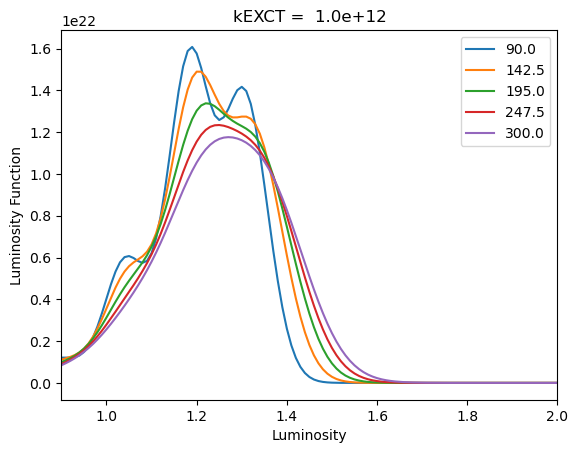

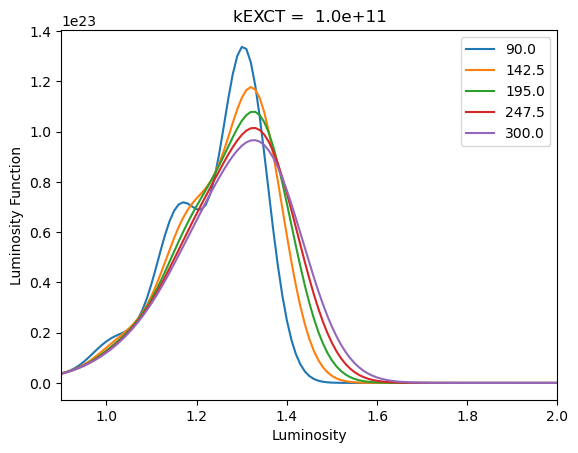

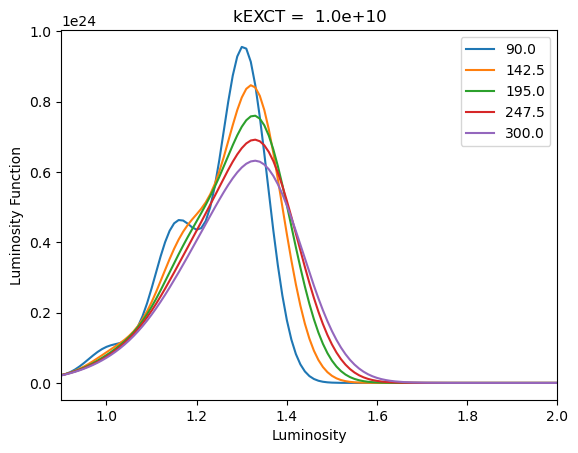

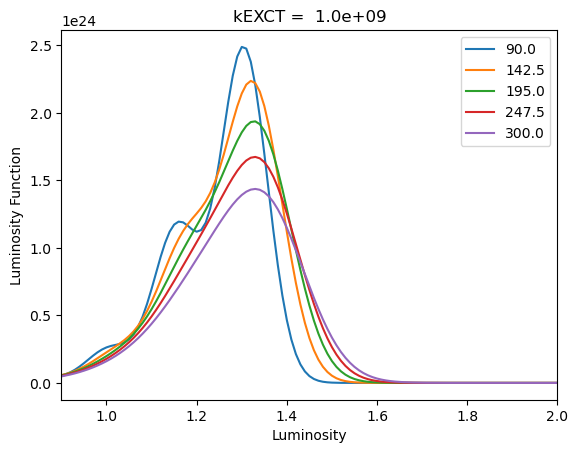

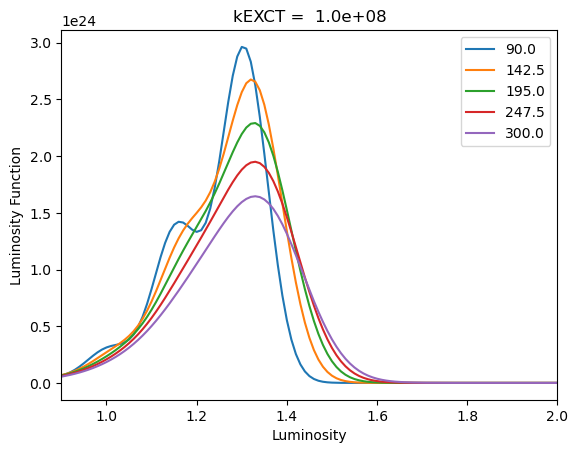

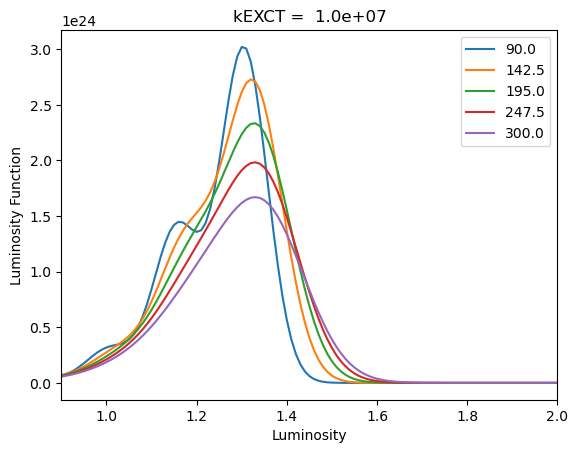

In [ ]:
import importlib

from pl_temp_fit import LTPL

importlib.reload(LTPL)
data = LTPL.Data()
for k_EXCT in [1e12, 1e11, 1e10, 1e9, 1e8, 1e7]:
    data.D.kEXCT = k_EXCT
    data.EX = LTPL.State(
        E=1.5,
        vmhigh=5,
        vmlow=15,
        sigma=0.02,
        numbrstates=20,
        off=0,
        LI=0.1,
        L0=0.15,
        H0=0.15,
        fosc=5,
    )
    data.CT = LTPL.State(
        E=1.3,
        vmhigh=5,
        vmlow=15,
        sigma=0.01,
        numbrstates=20,
        off=0,
        LI=0.1,
        L0=0.1,
        H0=0.15,
        fosc=0.05,
    )
    LTPL.LTPLCalc(data)
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    ax.plot(data.D.hw, data.D.kr_hw, label=data.D.T)
    ax.set_xlabel("Luminosity")
    ax.set_ylabel("Luminosity Function")
    ax.legend()
    ax.set_xlim(0.9, 2)
    # ax.set_ylim(1e19, 1e40)
    ax.set_yscale("linear")
    ax.set_title(f"kEXCT =  {k_EXCT:.1e}")

print(data.EX.knr)
print(data.CT.knr)

knr
4.3271e+09
4.1818e+09
4.5020e+09
5.0250e+09
5.7453e+09
kr
2.8580e+08
2.9996e+08
3.0721e+08
3.1223e+08
3.1690e+08


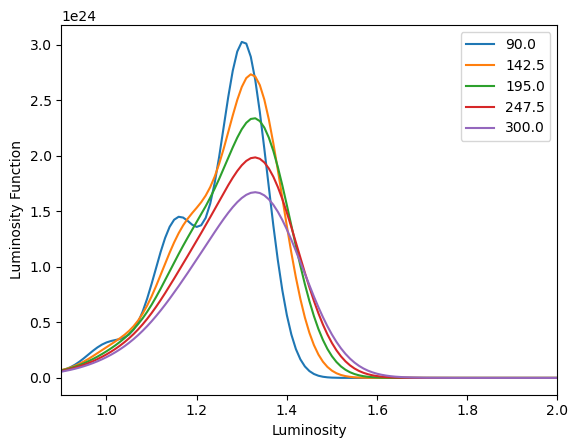

In [ ]:
from pl_temp_fit import LTPL

data = LTPL.Data()
data.EX = LTPL.State(
    E=1.5,
    vmhigh=5,
    vmlow=15,
    sigma=0.02,
    numbrstates=20,
    off=0,
    LI=0.1,
    L0=0.15,
    H0=0.15,
    fosc=5,
)
data.CT = LTPL.State(
    E=1.1,
    vmhigh=2,
    vmlow=2,
    sigma=0.01,
    numbrstates=20,
    off=1,
    LI=0.1,
    L0=0.1,
    H0=0.15,
    fosc=5,
)
LTPL.LTPLCalc(data)
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(data.D.hw, data.D.kr_hw, label=data.D.T)
ax.set_xlabel("Luminosity")
ax.set_ylabel("Luminosity Function")
ax.legend()
ax.set_xlim(0.9, 2)
# ax.set_ylim(1e19, 1e40)
ax.set_yscale("linear")
# print in scientific notation
print("knr")
for x in data.EX.knr[0]:
    print(f"{x:10.4e}")
# print in scientific notation
print("kr")
for x in data.EX.kr:
    print(f"{x:10.4e}")

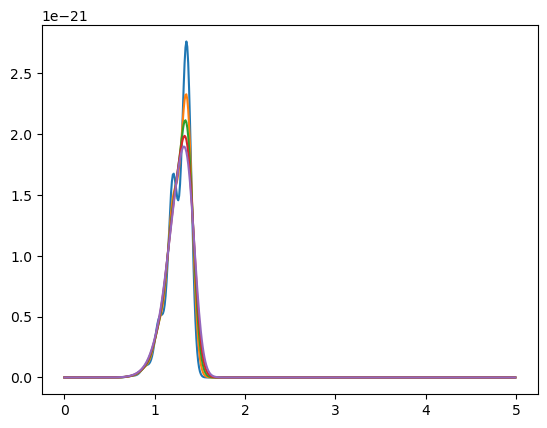

In [ ]:
fig, ax = plt.subplots()
ax.plot(data.D.hw, data.EX.ka_hw, label=data.D.T)

In [ ]:
print(data.EX.M)
print(data.EX.V)
print(data.EX.FCWD[:, 0, 0].max())
print(data.EX.Sum)
print(data.EX.Gen)

6.763524363633578e-10
0.699255508626945
1.2032927909902044e-34
[1.24733825e+15 1.25037993e+15 1.23607640e+15 1.20923399e+15
 1.17320161e+15]
[1.e+25 1.e+25 1.e+25 1.e+25 1.e+25]


In [ ]:
# print in scientific notation
print("knr")
for x in data.EX.knr:
    print(f"{x:10.4e}")
# print in scientific notation
print("kr")
for x in data.EX.kr:
    print(f"{x:10.4e}")

knr
7.7248e+09
7.7117e+09
7.8481e+09
8.0988e+09
8.4469e+09
kr
2.9224e+08
2.9537e+08
2.9810e+08
3.0078e+08
3.0365e+08


In [ ]:
print(data.EX.kr_hw)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.83744942e-13 1.33443071e-12 2.93444898e-12 6.22394212e-12
  1.27632563e-11]
 [4.93136908e-05 7.55698390e-05 1.13572199e-04 1.67608406e-04
  2.43181128e-04]
 [4.29584750e+02 4.56954945e+02 4.85169901e+02 5.14193664e+02
  5.43989789e+02]
 [6.42453840e+08 4.91181984e+08 3.80856504e+08 2.99175339e+08
  2.37853793e+08]
 [1.93520815e+14 1.10112051e+14 6.44543811e+13 3.87319829e+13
  2.38486445e+13]
 [1.26069923e+19 5.52783473e+18 2.52505401e+18 1.19801304e+18
  5.88781441e+17]
 [1.84492781e+23 6.45488592e+22 2.37848953e+22 9.19572828e+21
  3.71762881e+21]
 [6.20401126e+26 1.79339799e+26 5.51043148e+25 1.79178250e+25
  6.14103786e+24]
 [4.86460023e+29 1.20303495e+29 3.18629649e+28 8.99344067e+27
  2.69310707e+27]
 [8.98556074e+31 1.96862110e+31 4.64625817e+30 1.17501887e+30
  3.16869670e+29]
 [3.94972969e+33 7.94245956e+32 1.72787675e+32 4.04380585e+31
  1.01290075e+31]
 [4.30360680e+34 8.25845790e+33 1.719160

In [ ]:
np.tile(np.arange(0, 5 + 1), (16, 1)).shape
hw = np.arange(0, 5 + 1)
T = np.arange(290, 300)
Lagur, energy, deltaG, final, initial = FCWD_v(data.EX, data.c, hw, T)

In [ ]:
import numpy as np
from scipy.special import factorial, genlaguerre

t_array = np.arange(0, 5)
w_array = np.arange(0, 15)
lag = np.zeros((len(t_array), len(w_array)))
from itertools import product

for t, w in product(t_array, w_array):
    # print(t,w)
    if w - t > 0:
        lag[t, w] = genlaguerre(t, w - t)(0.6)

lag

array([[0.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 1.400000e+00, 2.400000e+00,
        3.400000e+00, 4.400000e+00, 5.400000e+00, 6.400000e+00,
        7.400000e+00, 8.400000e+00, 9.400000e+00, 1.040000e+01,
        1.140000e+01, 1.240000e+01, 1.340000e+01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 1.380000e+00,
        3.780000e+00, 7.180000e+00, 1.158000e+01, 1.698000e+01,
        2.338000e+01, 3.078000e+01, 3.918000e+01, 4.858000e+01,
        5.898000e+01, 7.038000e+01, 8.278000e+01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.084000e+00, 4.864000e+00, 1.204400e+01, 2.362400e+01,
        4.060400e+01, 6.398400e+01, 9.476400e+01, 1.339440e+02,
        1.825240e+02, 2.415040e+02, 3.118840e+02],
       [0.000000e+00, 0.0000

In [ ]:
np.take(lag, [[0, 1, 2, 3], [0, 1, 2, 3]], axis=1)

array([[[ 1.   ,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.4  ,  0.   ,  0.   ],
        [ 0.   ,  0.4  ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   , -0.02 ,  0.   ],
        [ 0.   ,  0.   , -0.02 ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , -0.296],
        [ 0.   ,  0.   ,  0.   , -0.296]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.

In [ ]:
lag

array([[ 1.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.4     ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -0.02    ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , -0.296   ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.4586  ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      , -0.533648],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.   

In [ ]:
(final - initial) * factorial(initial) / factorial(final)